# Importing important libraries

In [25]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

# To read images/ prepare feature vector and convert labels to one hot encoded vectors

In [28]:
def one_hot_encode_labels(labels):
    """
    Convert labels into one-hot encoded vectors.
    
    Parameters:
        labels: List or 1D array of integers (0-9).

    Returns:
        one_hot_labels: 2D NumPy array of shape (n_samples, 10).
    """
    n_samples = len(labels)
    one_hot_labels = np.zeros((n_samples, 10))
    one_hot_labels[np.arange(n_samples), labels] = 1
    return one_hot_labels


def extract_features(image):
    """
    Extract 27 covariance features and 18 augmented features (mean magnitude and direction) 
    from a 28x28 image using a 3x3 grid.

    Parameters:
        image: 2D NumPy array (28x28) - grayscale image.
        weights: 2D NumPy array (3x3) - weights for each grid.

    Returns:
        features: 1D NumPy array (27 + 18) - covariance features and augmented features for the image.
    """
    grid_size = 28 // 7  # Each grid is 7x7 pixels
    features = []
    weights = np.array([
        [0.23570226, 0.2773501,  0.31622777, 0.33333333, 0.31622777, 0.2773501,  0.23570226],
        [0.2773501,  0.35355339, 0.4472136,  0.5,        0.4472136,  0.35355339, 0.2773501],
        [0.31622777, 0.4472136,  0.70710678, 1.,         0.70710678, 0.4472136,  0.31622777],
        [0.33333333, 0.5,        1.,         1.,         1.,         0.5,        0.33333333],
        [0.31622777, 0.4472136,  0.70710678, 1.,         0.70710678, 0.4472136,  0.31622777],
        [0.2773501,  0.35355339, 0.4472136,  0.5,        0.4472136,  0.35355339, 0.2773501],
        [0.23570226, 0.2773501,  0.31622777, 0.33333333, 0.31622777, 0.2773501,  0.23570226]
    ]) #Grid weights, weighted by the inverse of the distance to the centre.

    for i in range(7):
        for j in range(7):
            # Extract the grid
            grid = image[i * grid_size:(i + 1) * grid_size, j * grid_size:(j + 1) * grid_size]

            # Find white pixel coordinates
            white_pixels = np.argwhere(grid > 0)  # Coordinates of white pixels (row, col)
            if len(white_pixels) > 0:
                # Calculate deviations from the mean (centroid)
                centroid = np.mean(white_pixels, axis=0)  # (row, col)
                deviations = white_pixels - centroid  # Deviations (N, 2)
                
                # Compute covariance terms
                sigma_xx = np.mean(deviations[:, 0] ** 2)  # Variance in x
                sigma_yy = np.mean(deviations[:, 1] ** 2)  # Variance in y
                sigma_xy = np.mean(deviations[:, 0] * deviations[:, 1])  # Covariance

                # Compute gradients
                gx, gy = np.gradient(grid)  # Gradient along x and y
                mag = np.sqrt(gx**2 + gy**2)  # Magnitude of gradient
                direction = np.arctan2(gy, gx)  # Direction of gradient

                # Mean magnitude and mean direction (ignoring zero-gradient pixels)
                mean_mag = np.mean(mag[grid > 0]) if np.any(grid > 0) else 0
                mean_dir = np.mean(direction[grid > 0]) if np.any(grid > 0) else 0
            else:
                # Default if no white pixels
                sigma_xx, sigma_yy, sigma_xy = 0, 0, 0
                mean_mag, mean_dir = 0, 0

            # Apply weight and add features
            weight = weights[i, j]
            features.extend([
                weight * sigma_xx,
                weight * sigma_yy,
                weight * sigma_xy,
                weight * mean_mag,
                weight * mean_dir
            ])
    
    return np.array(features)



def preprocess(image_folder_path):
    """
    Process images and labels for a digit recognition model.

    Parameters:
        image_folder_path: Path to the dataset folder containing subfolders 0-9.

    Returns:
        features_array: 2D NumPy array (n_samples, 18) - extracted features.
        one_hot_labels: 2D NumPy array (n_samples, 10) - one-hot encoded labels.
    """
        
    features_list = []
    labels_list = []

    # Traverse folders (0-9)
    for label in range(10):
        label_folder = os.path.join(image_folder_path, str(label))
        for filename in os.listdir(label_folder):
            file_path = os.path.join(label_folder, filename)

            # Open and process the image
            image = Image.open(file_path).convert('L')  # Convert to grayscale since not all pictures are black and white like the dataset.
            image = image.point(lambda p: 255 if p >= 128 else 0, '1')
            image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
            features = extract_features(image)

            # Append features and label
            features_list.append(features)
            labels_list.append(label)

    # Convert to NumPy arrays
    features_array = np.array(features_list)
    one_hot_labels = one_hot_encode_labels(labels_list)

    return features_array, one_hot_labels

# Example usage
image_folder_path = r"C:\Users\vijay\Documents\digit_rec\trainingSet\trainingSet"  # Replace with your dataset path
features_array, one_hot_labels = preprocess(image_folder_path)

print("Feature Array Shape:", features_array.shape)  # Should be (n_samples, 245)
print("One-Hot Labels Shape:", one_hot_labels.shape)  # Should be (n_samples, 10)

Feature Array Shape: (42000, 245)
One-Hot Labels Shape: (42000, 10)


# ReLu

In [30]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Softmax Function

In [32]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss Function

In [34]:
def cross_entropy_loss(y_true, y_pred):
    # Categorical cross-entropy loss with epsilon to avoid log(0)
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

# Training the NN

In [68]:
# Initialize neural network parameters
input_size = 245
hidden_layer_1_size = 512
hidden_layer_2_size = 128
output_size = 10
learning_rate = 0.001
epochs = 100
batch_size = 128

# Random seed for reproducibility
np.random.seed(42)

# Initialize weights and biases
w1 = np.random.randn(input_size, hidden_layer_1_size) * 0.01
b1 = np.zeros((1, hidden_layer_1_size))

w2 = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) * 0.01
b2 = np.zeros((1, hidden_layer_2_size))

w3 = np.random.randn(hidden_layer_2_size, output_size) * 0.01
b3 = np.zeros((1, output_size))

# Adam optimizer state variables (momentum, velocity)
m_w1, v_w1 = np.zeros_like(w1), np.zeros_like(w1)
m_b1, v_b1 = np.zeros_like(b1), np.zeros_like(b1)
m_w2, v_w2 = np.zeros_like(w2), np.zeros_like(w2)
m_b2, v_b2 = np.zeros_like(b2), np.zeros_like(b2)
m_w3, v_w3 = np.zeros_like(w3), np.zeros_like(w3)
m_b3, v_b3 = np.zeros_like(b3), np.zeros_like(b3)

beta1, beta2 = 0.9, 0.999  # Adam parameters
epsilon = 1e-8  # For numerical stability

# Learning rate decay
lr_scheduler = lambda epoch: learning_rate * max(0.95 ** epoch, 1e-6)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(features_array, one_hot_labels, test_size=0.2, random_state=42)

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = int(x_train.shape[0] / batch_size)
    
    for batch in range(num_batches):
        # Get the current batch
        start = batch * batch_size
        end = start + batch_size
        X_batch = x_train[start:end]
        y_batch = y_train[start:end]
        
        # Forward pass
        z1 = np.dot(X_batch, w1) + b1
        a1 = relu(z1)
        
        z2 = np.dot(a1, w2) + b2
        a2 = relu(z2)
        
        z3 = np.dot(a2, w3) + b3
        y_pred = softmax(z3)

        # Calculate loss
        loss = cross_entropy_loss(y_batch, y_pred)
        epoch_loss += loss
        
        # Calculate accuracy
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
        epoch_accuracy += accuracy

        # Backpropagation
        # Output layer gradients
        dz3 = y_pred - y_batch  # Gradient of loss w.r.t output layer
        dw3 = np.dot(a2.T, dz3) / batch_size
        db3 = np.sum(dz3, axis=0, keepdims=True) / batch_size
        
        # Hidden layer 2 gradients
        dz2 = np.dot(dz3, w3.T) * relu_derivative(a2)
        dw2 = np.dot(a1.T, dz2) / batch_size
        db2 = np.sum(dz2, axis=0, keepdims=True) / batch_size
        
        # Hidden layer 1 gradients
        dz1 = np.dot(dz2, w2.T) * relu_derivative(a1)
        dw1 = np.dot(X_batch.T, dz1) / batch_size
        db1 = np.sum(dz1, axis=0, keepdims=True) / batch_size
        
        # Adam optimizer parameter update
        for param, grad, m, v, lr in zip([w1, w2, w3], [dw1, dw2, dw3], [m_w1, m_w2, m_w3], [v_w1, v_w2, v_w3], [lr_scheduler(epoch)] * 3):
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * np.square(grad)
            m_hat = m / (1 - beta1 ** (epoch + 1))  # Bias correction
            v_hat = v / (1 - beta2 ** (epoch + 1))  # Bias correction
            param -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

        for param, grad, m, v, lr in zip([b1, b2, b3], [db1, db2, db3], [m_b1, m_b2, m_b3], [v_b1, v_b2, v_b3], [lr_scheduler(epoch)] * 3):
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * np.square(grad)
            m_hat = m / (1 - beta1 ** (epoch + 1))  # Bias correction
            v_hat = v / (1 - beta2 ** (epoch + 1))  # Bias correction
            param -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

    # Epoch metrics
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss/num_batches:.4f}, Accuracy: {epoch_accuracy/num_batches:.4f}")
    
    # Validation loss and accuracy after every epoch
    z1_val = np.dot(x_test, w1) + b1
    a1_val = relu(z1_val)
    z2_val = np.dot(a1_val, w2) + b2
    a2_val = relu(z2_val)
    z3_val = np.dot(a2_val, w3) + b3
    y_pred_val = softmax(z3_val)
    
    val_loss = cross_entropy_loss(y_test, y_pred_val)
    val_accuracy = np.mean(np.argmax(y_pred_val, axis=1) == np.argmax(y_test, axis=1))
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(lr,"\n")

Epoch 1/100 - Loss: 0.7325, Accuracy: 0.7900
Validation Loss: 0.3590, Validation Accuracy: 0.8892
0.001 

Epoch 2/100 - Loss: 0.3083, Accuracy: 0.9054
Validation Loss: 0.2811, Validation Accuracy: 0.9129
0.00095 

Epoch 3/100 - Loss: 0.2585, Accuracy: 0.9196
Validation Loss: 0.2512, Validation Accuracy: 0.9227
0.0009025 

Epoch 4/100 - Loss: 0.2309, Accuracy: 0.9291
Validation Loss: 0.2316, Validation Accuracy: 0.9288
0.000857375 

Epoch 5/100 - Loss: 0.2106, Accuracy: 0.9358
Validation Loss: 0.2187, Validation Accuracy: 0.9332
0.0008145062499999999 

Epoch 6/100 - Loss: 0.1949, Accuracy: 0.9408
Validation Loss: 0.2090, Validation Accuracy: 0.9364
0.0007737809374999998 

Epoch 7/100 - Loss: 0.1826, Accuracy: 0.9450
Validation Loss: 0.2009, Validation Accuracy: 0.9392
0.0007350918906249999 

Epoch 8/100 - Loss: 0.1728, Accuracy: 0.9479
Validation Loss: 0.1953, Validation Accuracy: 0.9414
0.0006983372960937497 

Epoch 9/100 - Loss: 0.1646, Accuracy: 0.9509
Validation Loss: 0.1902, Valida

# Attach image to predict

## Instructions:

1. Take a photo of the number.
    
2. Crop the photo such that there is not a lot of empty space between the number and the borders of the image.

<div style="margin-left: 40px;">

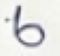

</div>
    
4. Resize the image to 28x28 and convert it to a .jpg file.

<div style="margin-left: 40px;">



</div>
    
6. Invert the image's colours.

<div style="margin-left: 40px;">



</div>
    
8. Copy the path of the image file into the cell and hit run!

In [129]:
def predict(x_in):
    # Forward pass through the network
    z1 = np.dot(x_in, w1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, w3) + b3
    y_pred = softmax(z3)

    # Get the index of the maximum value (predicted class)
    return np.argmax(y_pred)

# Load the image
image_path = r"C:\Users\vijay\Documents\test_images\Screenshot 2024-11-30 162908.jpg" # Paste image file here.
image = Image.open(image_path).convert('L')  # Convert to grayscale since not all pictures are black and white like the dataset.
image = image.point(lambda p: 255 if p >= 128 else 0, '1')
image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]

# Extract features (e.g., flatten the image)
x_in = extract_features(image)

# Predict the class of the input image
predicted_class = predict(x_in)

print(f"Predicted class: {predicted_class}")

Predicted class: 6
